# Telecom Customer Churn

### Business Problem

#### When we get a new customer, can we predict if they will churn based on certain characteristics, such as demographics, services purchased, and other customer interactions? Can we enhance customer retention programs with these findings?

### Process
#### Analyze a dataset that includes customer records of an international telecom company.
#### Build several different types of models and adjust some parameters of each.
#### Evaluate the performance of each model and select the best-performing model.
#### Make conclusions and recommendations to the business.

### First, we'll import some standard packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score


### Next, we'll set the working directory

In [2]:
import os
os.chdir('C:\\Users\\SJT\\Desktop\\Pred_Models\\ASSIGNMENT #2\\')

### Now, let's import the Telco Customer Churn dataset

In [3]:
df = pd.read_csv("Telco-Customer-Churn.csv")

### Let's display the first few rows

In [4]:
df.head(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

##### Each row represents a customer and each column contains customers' attributes, or features.
##### If the feature "Churn" includes a "Yes", that customer left within the last month, per the metadata
##### The dataset includes services that each customer signed up for.
##### Customer info is also included, e.g., how many months they've been a customer (tenure), payment method, etc.
##### Customer demographics included are gender, age range, and if they have partners and dependents.

### Let's look closer at this dataset

In [5]:
df.shape

(7043, 21)

In [6]:
### This dataset contains 20 features, one target variable, and 7043 records representing 7043 telecom customers.

In [7]:
# check datatypes
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
### The dataset contains mostly objects and a few continuous variables

### We'll name and reposition the target feature

In [9]:
# designate target variable name
targetName = 'Churn'
# move target variable into first column
targetSeries = df[targetName]
del df[targetName]
df.insert(0, targetName, targetSeries)
expected=targetName
df.head(3)

Churn  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0    No  7590-VHVEG  Female              0     Yes         No       1   
1    No  5575-GNVDE    Male              0      No         No      34   
2   Yes  3668-QPYBK    Male              0      No         No       2   

  PhoneService     MultipleLines InternetService  ... OnlineBackup  \
0           No  No phone service             DSL  ...          Yes   
1          Yes                No             DSL  ...           No   
2          Yes                No             DSL  ...          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod MonthlyCharges  TotalCharges  
0              Yes  Electronic check          29.85         29.85  
1               No      Mailed check          56.95        1889.5  
2              Yes      Mailed check          53.85        108.15  

[3 rows x 21 columns]

### We'll remove customerID since it has no predictive value

In [10]:
df = df.drop(columns = ['customerID'], axis=1)
# list features to verify 
print(df.columns)

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


### Let's do some exploratory data analysis

In [11]:
### Examine the continuous variables / features
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

##### "SeniorCitizen" is a binary 0/1 feature and 16.2% are Yes. Thus, 16.2% are seniors.
##### The "tenure" feature is continuous and averages about 32 months. 

In [12]:
### Let's see how the continuous features are correlated
df.corr()

SeniorCitizen    tenure  MonthlyCharges
SeniorCitizen        1.000000  0.016567        0.220173
tenure               0.016567  1.000000        0.247900
MonthlyCharges       0.220173  0.247900        1.000000

In [13]:
### no high correlations among these features

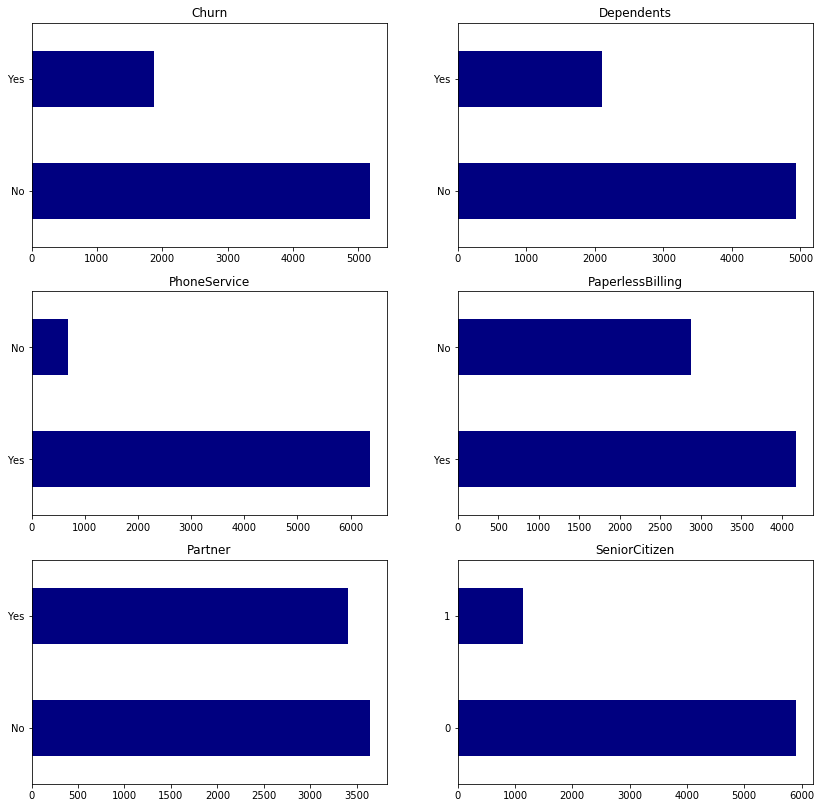

In [14]:
# now let's plot some bar graphs
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,14))

df['Churn'].value_counts().plot(kind = 'barh', color= "navy", ax=axes[0,0])
df['Dependents'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[0,1])
df['PhoneService'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[1,0])
df['PaperlessBilling'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[1,1])
df['Partner'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[2,0])
df['SeniorCitizen'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[2,1])

axes[0,0].title.set_text('Churn')
axes[0,1].title.set_text('Dependents')
axes[1,0].title.set_text('PhoneService')
axes[1,1].title.set_text('PaperlessBilling')
axes[2,0].title.set_text('Partner')
axes[2,1].title.set_text('SeniorCitizen')

##### Based on the Churn plot above, about 25% of customers churned within the last month. (This is an extremely high churn rate.) 
##### Average monthly telecom churn for the top 2 carriers varies between 1% and 2% and other top carriers experience 3% to 4% monthly churn.
##### We don't know if this dataset is balanced. It is balanced only if all customers who were active or churned within the given month are included.

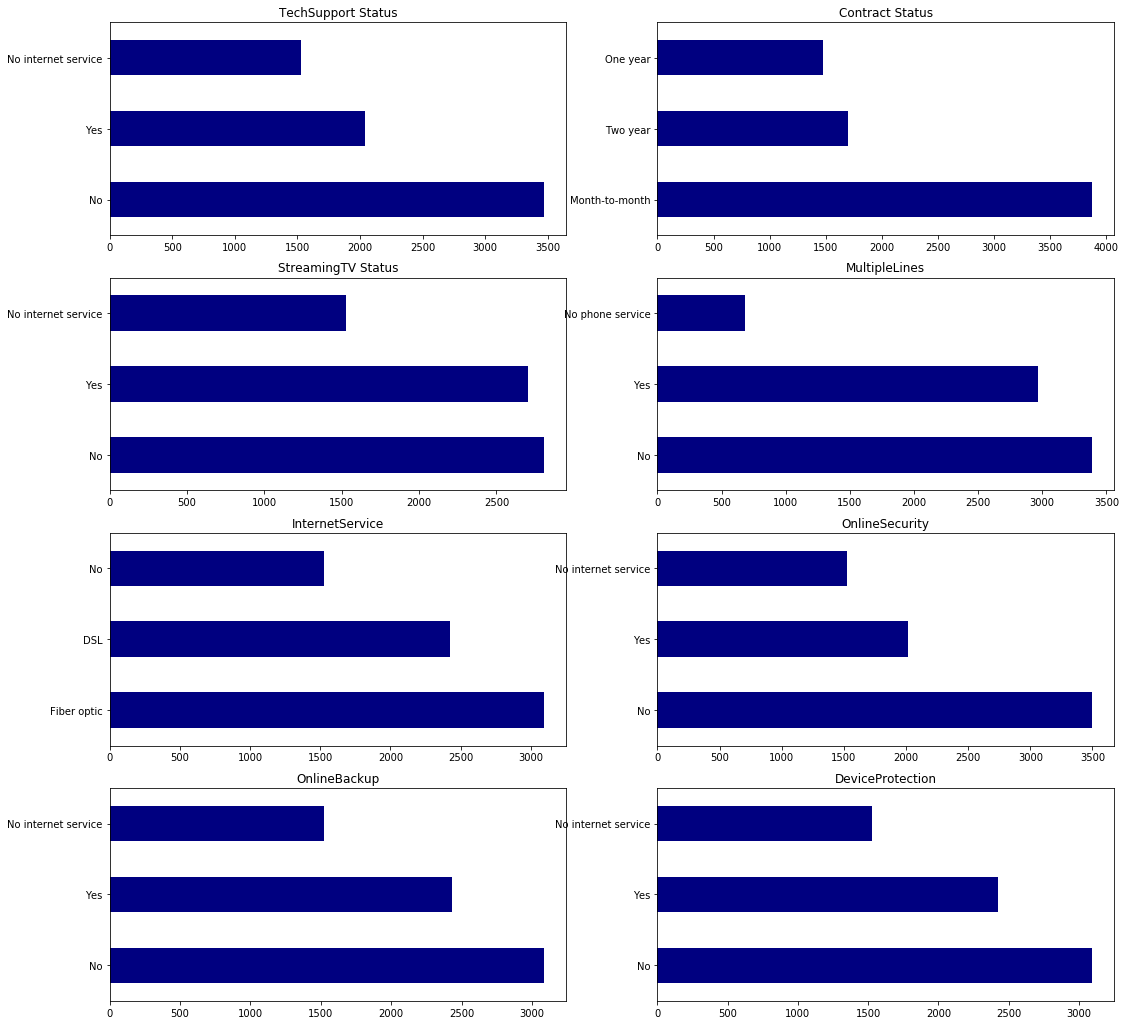

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,18))

df['TechSupport'].value_counts().plot(kind = 'barh', color= "navy", ax=axes[0,0])
df['Contract'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[0,1])
df['StreamingTV'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[1,0])
df['MultipleLines'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[1,1])
df['InternetService'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[2,0])
df['OnlineSecurity'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[2,1])
df['OnlineBackup'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[3,0])
df['DeviceProtection'].value_counts().plot(kind = 'barh', color= "navy",ax=axes[3,1])


axes[0,0].title.set_text('TechSupport Status')
axes[0,1].title.set_text('Contract Status')
axes[1,0].title.set_text('StreamingTV Status')
axes[1,1].title.set_text('MultipleLines')
axes[2,0].title.set_text('InternetService')
axes[2,1].title.set_text('OnlineSecurity')
axes[3,0].title.set_text('OnlineBackup')
axes[3,1].title.set_text('DeviceProtection')

#### DESCRIPTION OF A TYPICAL CUSTOMER (based on the visualizations above):
##### The majority of customers have a month-to-month contract, paperless billing, and fiber optic internet.
##### Most customers are under age 65 and have no dependents. Nearly 50% have a partner.
##### Most don't subscribe to optional services, such as device protection, tech support, online backup and online security.

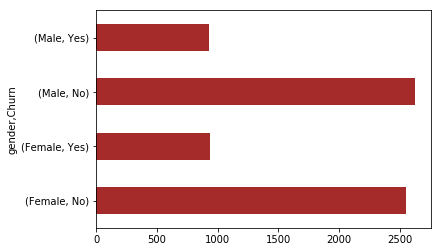

In [16]:
# Let's break down churn by gender
df.groupby('gender')['Churn'].value_counts().plot(kind = "barh", color = "brown")

##### Nearly the same number of males churned as females (and gender is evenly distributed)

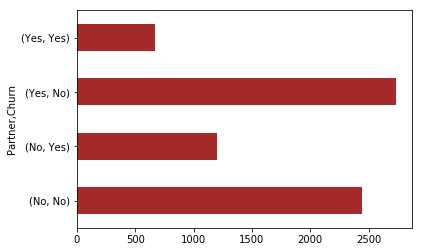

In [17]:
# Let's break down churn by partner or no partner
df.groupby('Partner')['Churn'].value_counts().plot(kind = "barh", color = "brown")

##### INTERESTING: Almost twice as many customers without partners churned as those with partners.
##### This is significant, since the distribution among these 2 groups is nearly 50/50

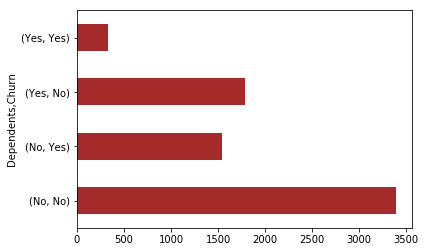

In [18]:
# Break down of churn by dependents or no dependents
df.groupby('Dependents')['Churn'].value_counts().plot(kind = "barh", color = "brown")

##### The propensity to churn is double among customers without dependents

In [19]:
### About 5x more customers without dependents churned as those with dependents.
### There are about 2.5x more customers without dependents in the dataset.


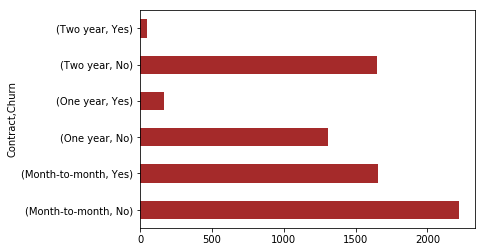

In [20]:
# Break down of churn by contract type
df.groupby('Contract')['Churn'].value_counts().plot(kind = "barh", color = "brown")

##### Customers with month-to-month contracts churned at much higher rates than those with 1- or 2-year contracts.

In [21]:
# to ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\SJT\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


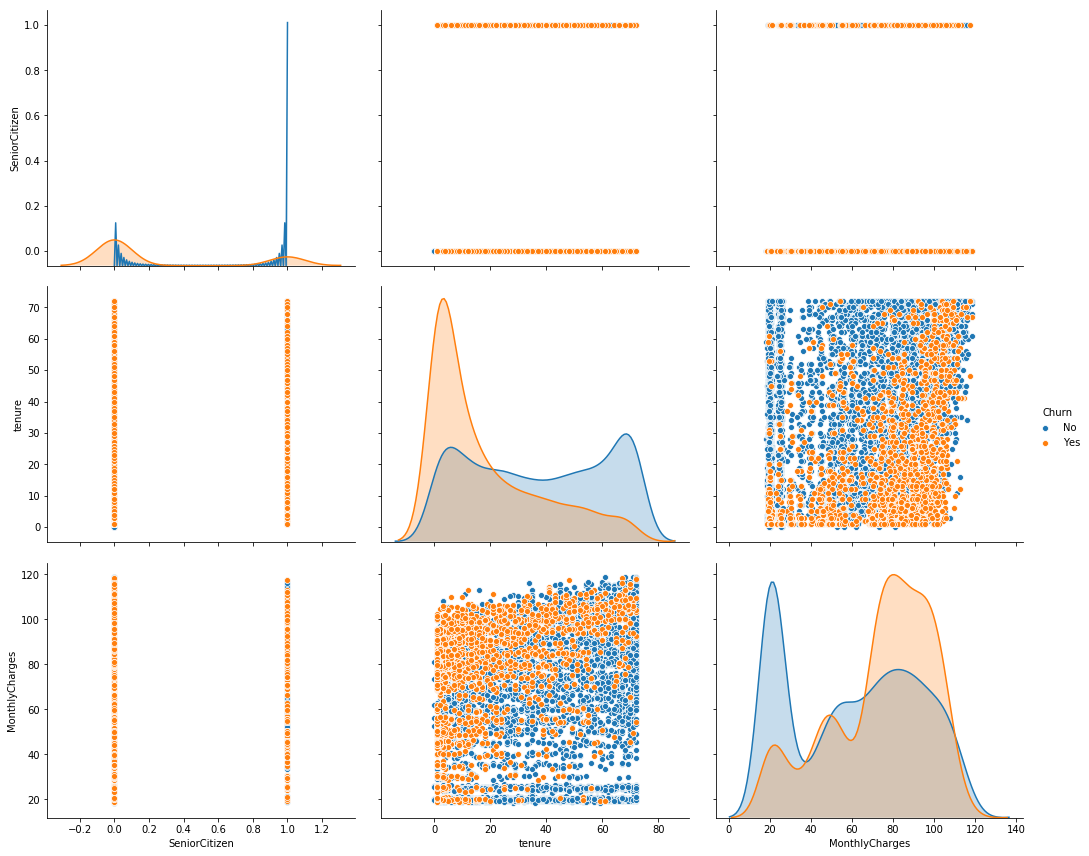

In [22]:
# Next, we'll take a closer look at churn
import seaborn as sns
# some versions don't allow the height argument (old versions use "size")
sns.pairplot(df, hue="Churn", size=4, aspect=1.2)

##### Senior citizens churned at a much higher rate (over 40% compared to the 25% average)
##### Customers tend to churn early in their tenure
##### Customers with high monthly charges (70/month and over) churn at higher rates.

C:\Users\SJT\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


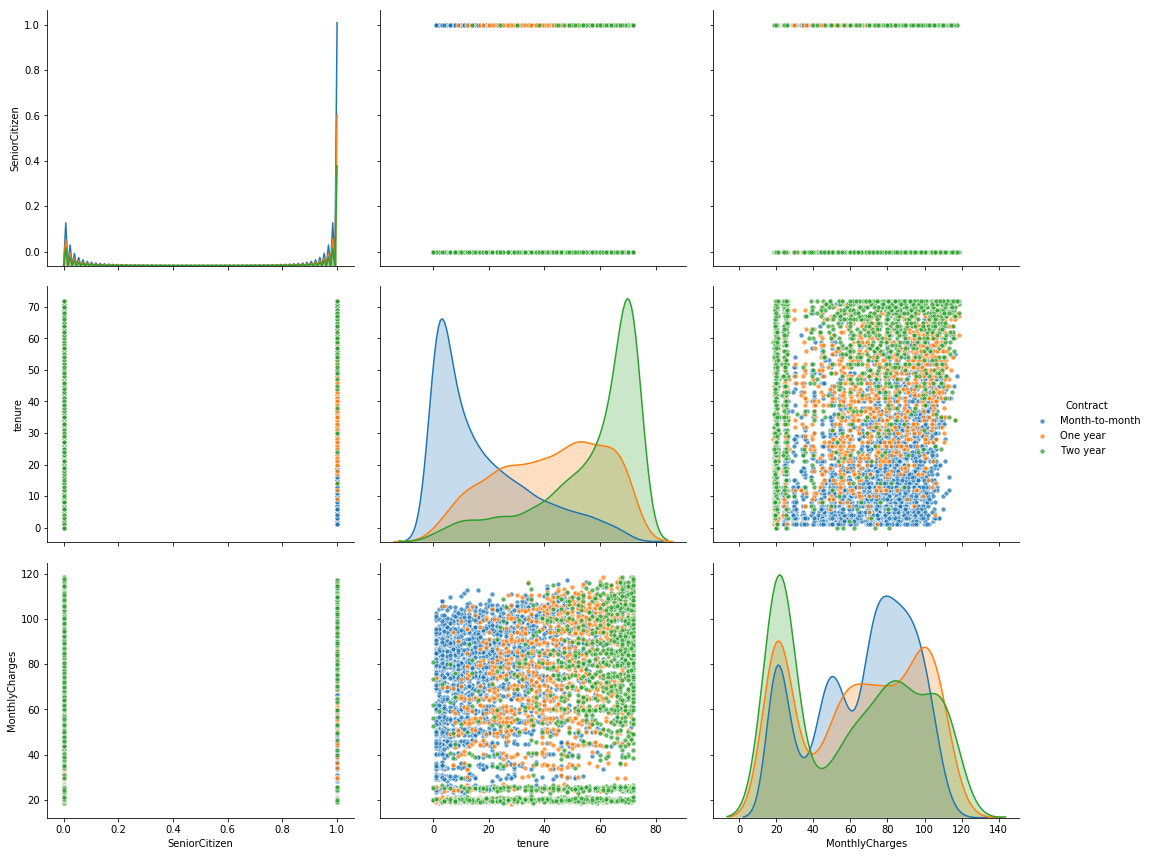

In [23]:
sns.pairplot(df, hue="Contract", plot_kws = {'alpha': 0.75,'s': 25}, size=4, aspect=1.2)

In [24]:
### DATA PRE-PROCESSING
le_dep = preprocessing.LabelEncoder()
#to convert into numbers
df['Churn'] = le_dep.fit_transform(df['Churn'])

In [25]:
# Take another look at the features
df.head(10)

Churn  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0      0  Female              0     Yes         No       1           No   
1      0    Male              0      No         No      34          Yes   
2      1    Male              0      No         No       2          Yes   
3      0    Male              0      No         No      45           No   
4      1  Female              0      No         No       2          Yes   
5      1  Female              0      No         No       8          Yes   
6      0    Male              0      No        Yes      22          Yes   
7      0  Female              0      No         No      10           No   
8      1  Female              0     Yes         No      28          Yes   
9      0    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   
5               Yes     Fiber optic             No           No   
6               Yes     Fiber optic             No          Yes   
7  No phone service             DSL            Yes           No   
8               Yes     Fiber optic             No           No   
9                No             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   
5              Yes          No         Yes             Yes  Month-to-month   
6               No          No         Yes              No  Month-to-month   
7               No          No          No              No  Month-to-month   
8              Yes         Yes         Yes             Yes  Month-to-month   
9               No          No          No              No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
5              Yes           Electronic check           99.65        820.5  
6              Yes    Credit card (automatic)           89.10       1949.4  
7               No               Mailed check           29.75        301.9  
8              Yes           Electronic check          104.80      3046.05  
9               No  Bank transfer (automatic)           56.15      3487.95

In [26]:
### We can see that the target is now a binary numeric

In [27]:
# Convert to dummy variables
columns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
           'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

for col in columns:
   temp_df = pd.get_dummies(df[col], prefix=col)
   df = pd.concat((df, temp_df), axis=1)

In [28]:
### Drop the original features that have been dummied
df = df.drop(columns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
           'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'])

In [29]:
# check shape of dataset after transformation
df.shape

(7043, 46)

In [30]:
### We originally had 21 features and now have 46

#### Here is our new list of features

In [31]:
list(df)

['Churn',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod

In [32]:
# check datatypes
df.dtypes

Churn                                        int32
SeniorCitizen                                int64
tenure                                       int64
MonthlyCharges                             float64
TotalCharges                                object
gender_Female                                uint8
gender_Male                                  uint8
Partner_No                                   uint8
Partner_Yes                                  uint8
Dependents_No                                uint8
Dependents_Yes                               uint8
PhoneService_No                              uint8
PhoneService_Yes                             uint8
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No              

In [33]:
# TotalCharges is an object and needs to be a float datatype
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

#### Now, we'll check for missing values

In [34]:
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values : \n", df.nunique())


Missing values :   11

Unique values : 
 Churn                                         2
SeniorCitizen                                 2
tenure                                       73
MonthlyCharges                             1585
TotalCharges                               6530
gender_Female                                 2
gender_Male                                   2
Partner_No                                    2
Partner_Yes                                   2
Dependents_No                                 2
Dependents_Yes                                2
PhoneService_No                               2
PhoneService_Yes                              2
MultipleLines_No                              2
MultipleLines_No phone service                2
MultipleLines_Yes                             2
InternetService_DSL                           2
InternetService_Fiber optic                   2
InternetService_No                            2
OnlineSecurity_No                             

In [35]:
# missing values for TotalCharges
#df[df.isnull().any(axis=1)].iloc[:,14:]

In [36]:
# Since there are very few missing values, we'll drop them inplace
df.dropna(inplace = True)

In [37]:
# Check shape of dataset after transformation
df.shape

(7032, 46)

In [38]:
### We see that 11 customers were dropped from the dataset

In [39]:
# we'll save the new dataset
#df.to_csv("Telco-Customer-Churn2.csv")

In [40]:
# Set random seed
RANDOM_SEED = 10

In [41]:
# split dataset into a 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,1:].values, df.iloc[:,0].values, test_size=0.30, random_state=RANDOM_SEED)

In [42]:
### PRINT TO SEE THE RESULT
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
print("Percent of Target that is Yes", y_test.mean())
#data.groupby(['col1', 'col2'])

(2110, 45)
(4922, 45)
(2110,)
(4922,)
Percent of Target that is Yes 0.26492890995260665


In [43]:
### We have 45 features and one target variable. 
### We have 4922 customers represented in the training set and 2110 in the test set.

In [44]:
### After data processing, the dataset still contains 26.5% of churned customers.
### Thus, the naive prediction is 26% to 27% customer churn. 
### (We mentioned previously that it was 25%.)

### Now, it's time to try some algorithms and models

## k-Nearest Neighbors Algorithm

### KNN1: Default Model with k=3

In [45]:
# We'll begin with a default kNN=3 model 
from sklearn.neighbors import KNeighborsClassifier

In [46]:
clf_knn = KNeighborsClassifier(n_neighbors = 3)
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_knn)
#Fit clf to the training data
clf_knn = clf_knn.fit(X_train, y_train)
#Predict clf kNN model against test data
target_predicted_knn = clf_knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


In [47]:
# Cross-validation
scores = cross_val_score(clf_knn, X_test, y_test, cv=10)
print(scores)
    
# Show the classification and confusion matrix
#print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn))
print("kNN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print(classification_report(y_test, target_predicted_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_knn))

[0.78773585 0.78199052 0.73459716 0.81516588 0.77251185 0.76777251
 0.7014218  0.76777251 0.77251185 0.75714286]
kNN Accuracy: 0.77 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1551
           1       0.54      0.50      0.52       559

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.69      0.68      0.68      2110
weighted avg       0.75      0.76      0.75      2110

Confusion Matrix:
[[1316  235]
 [ 278  281]]


In [48]:
### Precision, recall, and F1 score of the positive class is 54%, 50%, and 52% respectively 
### Remember the dataset contains only 26% positive class (so this is an improvement)
### Precision or "Positive Predictive Value" = TP / (TP + FP)
### Recall or Sensitivity or "True Positive Rate" = TP / (TP + FN)
### F1 Score is the harmonic average of precision and recall

In [49]:
### Remember, we want to know how well customer churn can be predicted:
### How many did we predict as positive among all the actual positives (recall)
### It's also good to know how many of our positive predictions were correct (precision) 
### THUS: We'll use F1 Score of the positive class to evaluate model performance 

### KNN2: k=3 using Distance Weighting

In [50]:
clf_knn = KNeighborsClassifier(n_neighbors = 3, weights='distance')
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_knn)
#Fit clf to the training data
clf_knn = clf_knn.fit(X_train, y_train)
#Predict clf kNN model against test data
target_predicted_knn = clf_knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')


In [51]:
# Cross-validation
scores = cross_val_score(clf_knn, X_test, y_test, cv=10)
print(scores)

# Show the classification and confusion matrix
#print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn))
print("kNN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print(classification_report(y_test, target_predicted_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_knn))

[0.79245283 0.74407583 0.71563981 0.81990521 0.7535545  0.7535545
 0.70616114 0.73933649 0.73933649 0.74761905]
kNN Accuracy: 0.75 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1551
           1       0.53      0.51      0.52       559

   micro avg       0.75      0.75      0.75      2110
   macro avg       0.68      0.67      0.68      2110
weighted avg       0.75      0.75      0.75      2110

Confusion Matrix:
[[1299  252]
 [ 274  285]]


In [52]:
# F1 score of the positive class is the same. (We'll call it F1+)

### KNN3: k=3 using Manhattan Distance and Distance Weighting

In [53]:
clf_knn = KNeighborsClassifier(n_neighbors = 3, weights='distance', metric='manhattan')
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_knn)
#Fit clf to the training data
clf_knn = clf_knn.fit(X_train, y_train)
#Predict clf kNN model against test data
target_predicted_knn = clf_knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')


In [54]:
# Cross-validation
scores = cross_val_score(clf_knn, X_test, y_test, cv=10)
print(scores)

# Show the classification and confusion matrix
#print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn))
print("kNN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print(classification_report(y_test, target_predicted_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_knn))

[0.75943396 0.74881517 0.69668246 0.81042654 0.7535545  0.78199052
 0.71090047 0.73459716 0.72037915 0.75238095]
kNN Accuracy: 0.75 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1551
           1       0.52      0.52      0.52       559

   micro avg       0.75      0.75      0.75      2110
   macro avg       0.67      0.67      0.67      2110
weighted avg       0.75      0.75      0.75      2110

Confusion Matrix:
[[1285  266]
 [ 269  290]]


In [55]:
# Again, F1+ is the same.

### Finding the best value for k

In [56]:
# try K=1 through K=30 and record testing accuracy
k_range = list(range(1, 31))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(mt.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

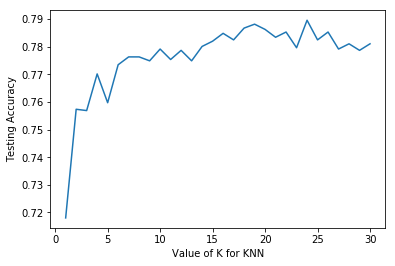

In [57]:
# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [58]:
# It looks like the testing accuracy peaks between k=23 and k=24
# We will re-do the best performing model so far using k=23, since odd k values are preferable

### KNN4: k=23 using Manhattan Distance and Distance Weighting

In [59]:
clf_knn = KNeighborsClassifier(n_neighbors = 23, weights='distance', metric='manhattan')
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_knn)
#Fit clf to the training data
clf_knn = clf_knn.fit(X_train, y_train)
#Predict clf kNN model against test data
target_predicted_knn = clf_knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='distance')


In [60]:
# Cross-validation
scores = cross_val_score(clf_knn, X_test, y_test, cv=10)
print(scores)

# Show the classification and confusion matrix
#print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn))
print("kNN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print(classification_report(y_test, target_predicted_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_knn))

[0.78301887 0.80094787 0.78672986 0.81990521 0.77725118 0.78672986
 0.71090047 0.78199052 0.78672986 0.78571429]
kNN Accuracy: 0.78 (+/- 0.05)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1551
           1       0.61      0.48      0.54       559

   micro avg       0.78      0.78      0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

Confusion Matrix:
[[1381  170]
 [ 289  270]]


In [61]:
# F1+ increased 2%. KNN4 is the best KNN model.

### Stochastic Gradient Descent

### SGD1: perceptron loss function with L2 penalty

In [62]:
from sklearn.linear_model import SGDClassifier

In [63]:
SGD_clf = SGDClassifier(loss="perceptron", penalty="l2")
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)


In [64]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.75       0.28909953 0.76303318 0.26540284 0.492891   0.76303318
 0.72037915 0.74881517 0.76303318 0.73333333]
SGD Accuracy: 0.63 (+/- 0.38)

              precision    recall  f1-score   support

  Churn = no       0.79      0.93      0.85      1551
 Churn = yes       0.60      0.30      0.40       559

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.69      0.62      0.63      2110
weighted avg       0.74      0.76      0.73      2110

Confusion Matrix:
[[1437  114]
 [ 389  170]]


In [65]:
# F1+ is much lower

### SGD2: increased iterations

In [66]:
### Let's try it with more iterations over the training data (default used above was 5)

In [67]:
SGD_clf = SGDClassifier(loss="perceptron", penalty="l2", max_iter=10)
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
       max_iter=10, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)


In [68]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.75       0.79146919 0.76303318 0.73459716 0.26540284 0.74407583
 0.74881517 0.63981043 0.77725118 0.73809524]
SGD Accuracy: 0.70 (+/- 0.30)

              precision    recall  f1-score   support

  Churn = no       0.81      0.87      0.84      1551
 Churn = yes       0.55      0.45      0.49       559

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.68      0.66      0.67      2110
weighted avg       0.74      0.76      0.75      2110

Confusion Matrix:
[[1348  203]
 [ 310  249]]


In [69]:
# F1+ is even lower.

### SGD3: perceptron loss function with L1 penalty

In [70]:
### Let's try it with the L1 penalty instead

In [71]:
SGD_clf = SGDClassifier(loss="perceptron", penalty="l1", max_iter=5)
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
       max_iter=5, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)


In [72]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.75       0.32227488 0.75829384 0.73459716 0.26540284 0.26540284
 0.73459716 0.77251185 0.78199052 0.26190476]
SGD Accuracy: 0.56 (+/- 0.47)

              precision    recall  f1-score   support

  Churn = no       0.97      0.21      0.35      1551
 Churn = yes       0.31      0.98      0.47       559

   micro avg       0.42      0.42      0.42      2110
   macro avg       0.64      0.60      0.41      2110
weighted avg       0.80      0.42      0.38      2110

Confusion Matrix:
[[ 326 1225]
 [   9  550]]


In [73]:
# F1+ is still not good

### SGD4: hinge loss function with L2 penalty

In [74]:
### Now we'll use the hinge loss function, using the best parameters so far

In [75]:
SGD_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5) 
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [76]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.72641509 0.76777251 0.77725118 0.26540284 0.77725118 0.73459716
 0.68246445 0.74881517 0.77251185 0.71428571]
SGD Accuracy: 0.70 (+/- 0.29)

              precision    recall  f1-score   support

  Churn = no       0.79      0.93      0.85      1551
 Churn = yes       0.62      0.30      0.40       559

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.70      0.62      0.63      2110
weighted avg       0.74      0.76      0.73      2110

Confusion Matrix:
[[1448  103]
 [ 393  166]]


In [77]:
# What a difference: the best F1+ score yet!

### SGD5: hinge loss function with L1 penalty

In [78]:
# For good measure, let's try the L1 penalty with the hinge loss function

In [79]:
SGD_clf = SGDClassifier(loss="hinge", penalty="l1", max_iter=5) 
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [80]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.75471698 0.7535545  0.75829384 0.64454976 0.79620853 0.74407583
 0.69194313 0.7535545  0.68720379 0.26190476]
SGD Accuracy: 0.68 (+/- 0.29)

              precision    recall  f1-score   support

  Churn = no       0.79      0.93      0.85      1551
 Churn = yes       0.61      0.30      0.41       559

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.70      0.62      0.63      2110
weighted avg       0.74      0.76      0.73      2110

Confusion Matrix:
[[1443  108]
 [ 389  170]]


#### Grid Search

In [81]:
sgd_gs = SGDClassifier()
parameters = {'loss':['hinge','log','squared_hinge','modified_huber'], 'penalty':['l1','l2','elasticnet','none'], 
              'max_iter':[5,10,15,20],'random_state': [RANDOM_SEED]}
sgd_gs = GridSearchCV(sgd_gs , parameters, cv=4, n_jobs=1, scoring='recall')
sgd_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber'], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'max_iter': [5, 10, 15, 20], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [82]:
print(sgd_gs.best_params_, sgd_gs.best_score_)

{'loss': 'squared_hinge', 'max_iter': 5, 'penalty': 'l1', 'random_state': 10} 0.7887861616832341


### SGD6: squared hinge loss function with L1 penalty

In [83]:
SGD_clf = SGDClassifier(loss="squared_hinge", penalty="l1", max_iter=15, random_state=RANDOM_SEED) 
# output the classifier
print(SGD_clf)
SGD_clf.fit(X_train, y_train)  
# test SGD
target_predicted_SGD = SGD_clf.predict(X_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='squared_hinge',
       max_iter=15, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=10, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [84]:
# Cross-validation
scores = cross_val_score(SGD_clf, X_test, y_test, cv=10)
print(scores)

#print(accuracy_score(y_test, target_predicted_SGD))
print("SGD Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
target_names = ["Churn = no", "Churn = yes"]
print(classification_report(y_test, target_predicted_SGD, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, target_predicted_SGD))

[0.75471698 0.39336493 0.36492891 0.41706161 0.46445498 0.26540284
 0.26540284 0.26540284 0.78199052 0.74761905]
SGD Accuracy: 0.47 (+/- 0.40)

              precision    recall  f1-score   support

  Churn = no       0.81      0.91      0.86      1551
 Churn = yes       0.62      0.39      0.48       559

   micro avg       0.77      0.77      0.77      2110
   macro avg       0.71      0.65      0.67      2110
weighted avg       0.76      0.77      0.76      2110

Confusion Matrix:
[[1415  136]
 [ 339  220]]


In [85]:
# F1+ of SGD6 is ok, but SGD4 is much higher and the best model yet.

## Decision Tree Models

In [86]:
# Let's try some decision tree models
from sklearn.tree import DecisionTreeClassifier

### DT1: Default decision tree

In [87]:
dt = DecisionTreeClassifier(random_state = RANDOM_SEED) 
# output the classifier
print(dt)
dt.fit(X_train, y_train)
       
dt_predictions = dt.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(dt, X_test, y_test, cv=10)
print(scores)
print("DT Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, dt_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
[0.79716981 0.71563981 0.78199052 0.78672986 0.73933649 0.74881517
 0.66350711 0.72511848 0.71090047 0.77619048]
DT Accuracy: 0.74 (+/- 0.08)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1551
           1       0.49      0.54      0.51       559

   micro avg       0.73      0.73      0.73      2110
   macro avg       0.66      0.67      0.66      2110
weighted avg       0.74      0.73      0.73      2110

Confusion Matrix:
[[1243  308]
 [ 259  300]]


In [88]:
# This F1+ is similar to KNN (not as high as SGD4)

In [89]:
# import viz packages, etc.
from sklearn.externals.six import StringIO  

In [90]:
from IPython.display import Image  

In [91]:
from sklearn.tree import export_graphviz

In [92]:
import pydotplus

In [93]:
# visualize the decision tree
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.688382 to fit



In [94]:
# OVER-FITTING: This tree has definitely over-fitted, as evidenced by the number of branches

### Now, let's do a Grid Search

In [95]:
# Grid search
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth': [1,2,3,4,5,6,7,8,9,10], 
              'max_features': ['sqrt','log2',None], 'random_state': [RANDOM_SEED]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=4, n_jobs=1)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['sqrt', 'log2', None], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'random_state': 10, 'splitter': 'best'} 0.7941893539211703


### DT2: Using entropy and other recommended parameters

In [97]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, max_features = None, 
                            splitter = 'best', random_state = RANDOM_SEED) 
# output the classifier
print(dt)
dt.fit(X_train, y_train)
       
dt_predictions = dt.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(dt, X_test, y_test, cv=10)
print(scores)
print("DT Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, dt_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
[0.78301887 0.8436019  0.76303318 0.83886256 0.81042654 0.8056872
 0.74881517 0.77725118 0.75829384 0.7952381 ]
DT Accuracy: 0.79 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1551
           1       0.62      0.51      0.56       559

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

Confusion Matrix:
[[1374  177]
 [ 273  286]]


In [98]:
# F1+ is within 2% of SGD4 (so this is the second highest score so far)

[[1374  177]
 [ 273  286]]


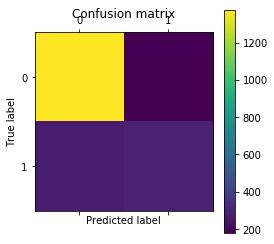

In [99]:
### display confusion matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

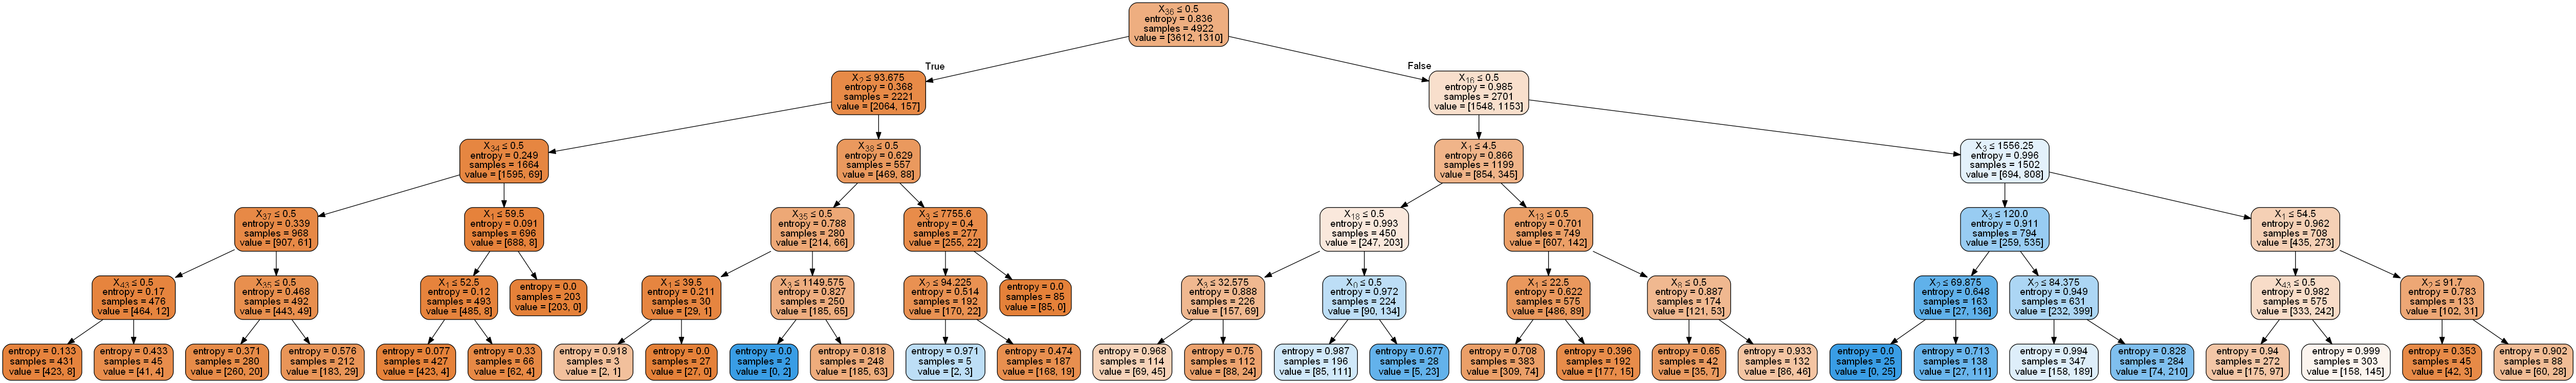

In [100]:
# visualize the decision tree DT2
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Grid Search: using recall as the primary scoring metric

In [101]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth': [1,2,3,4,5,6,7,8,9,10], 
              'max_features': ['sqrt','log2',None], 'random_state': [RANDOM_SEED]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=4, scoring='recall', n_jobs=1)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['sqrt', 'log2', None], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [102]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'random_state': 10, 'splitter': 'best'} 0.6640668266987834


In [103]:
# just a minor difference in recommended parameters, but we'll try it anyway

### DT3: change maximum depth of the tree

In [104]:
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth=2, max_features = None,  
                            splitter = 'best', random_state = RANDOM_SEED) 
# output the classifier
print(dt)
dt.fit(X_train, y_train)
       
dt_predictions = dt.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(dt, X_test, y_test, cv=10)
print(scores)
print("DT Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, dt_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
[0.75943396 0.74881517 0.78199052 0.79146919 0.80094787 0.78199052
 0.75829384 0.7535545  0.76303318 0.8       ]
DT Accuracy: 0.77 (+/- 0.04)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1551
           1       0.57      0.63      0.60       559

   micro avg       0.77      0.77      0.77      2110
   macro avg       0.71      0.73      0.72      2110
weighted avg       0.78      0.77      0.78      2110

Confusion Matrix:
[[1279  272]
 [ 205  354]]


In [105]:
# BEST SO FAR: This decision tree has the highest F1+ score of all models so far
# But DT2 has the highest average recall score and accuracy. 

[[1279  272]
 [ 205  354]]


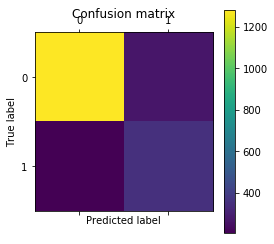

In [106]:
### display confusion matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

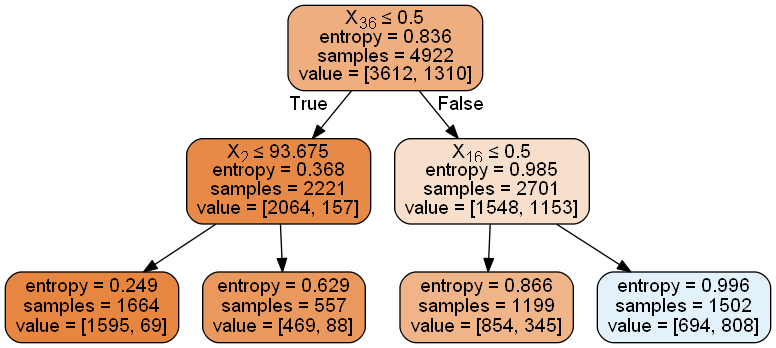

In [107]:
# visualize the decision tree DT3
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### DT4

In [108]:
### CHANGE THE CLASS_WEIGHT PARAMETER TO "BALANCED" AND MAX DEPTH OF 3

In [109]:
dt = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth=3, max_features = None, 
                            splitter = 'best', random_state = RANDOM_SEED) 
# output the classifier
print(dt)
dt.fit(X_train, y_train)
       
dt_predictions = dt.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(dt, X_test, y_test, cv=10)
print(scores)
print("DT Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, dt_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
[0.68396226 0.68720379 0.74881517 0.73933649 0.76303318 0.7535545
 0.71090047 0.69668246 0.69668246 0.72380952]
DT Accuracy: 0.72 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1551
           1       0.52      0.79      0.62       559

   micro avg       0.75      0.75      0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110

Confusion Matrix:
[[1136  415]
 [ 118  441]]


In [110]:
# BEST SO FAR: Even higher F1+ 

[[1136  415]
 [ 118  441]]


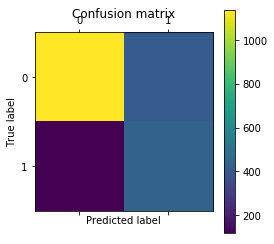

In [111]:
### display confusion matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

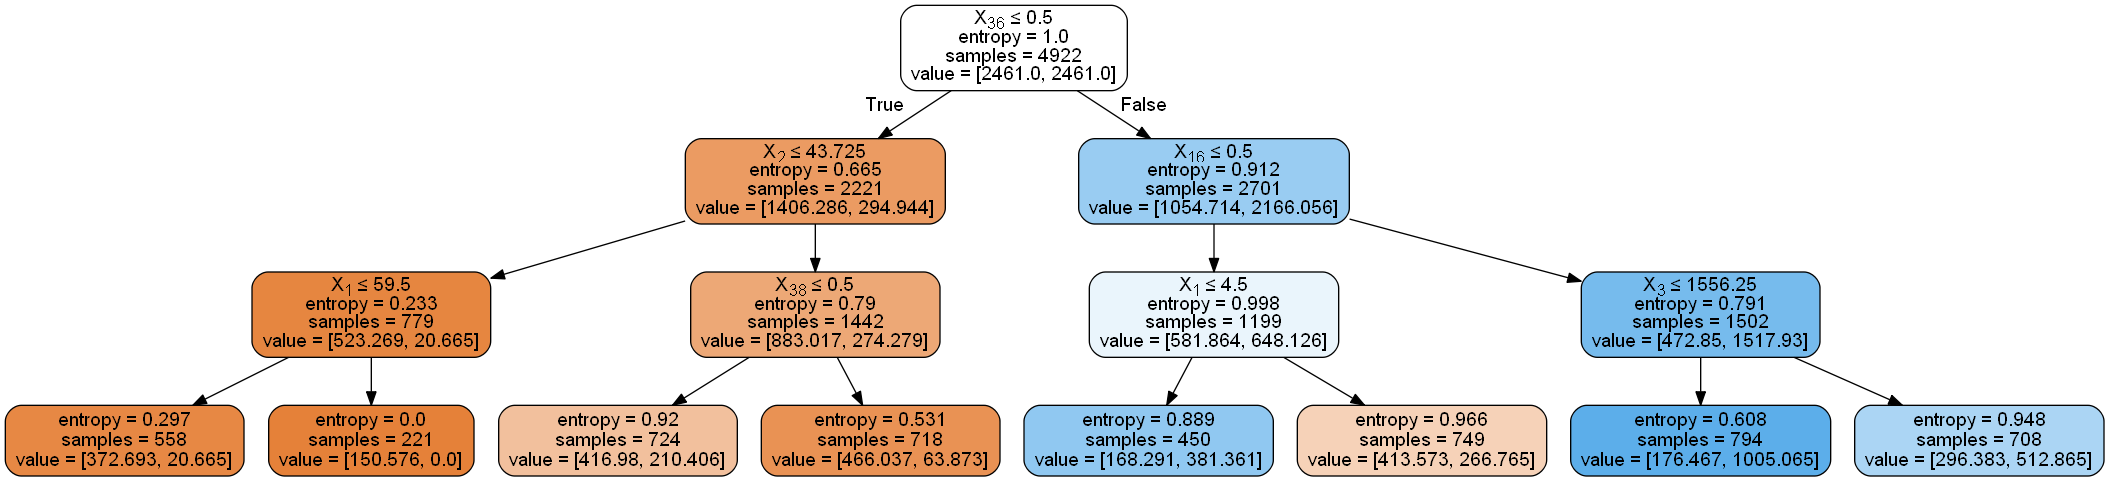

In [112]:
# visualize the decision tree DT4
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## AdaBoost with DecisionTreeClassifier

### AB1

In [113]:
### Load library
from sklearn.ensemble import AdaBoostClassifier

In [114]:
### Implement the AdaBoost-SAMME algorithm
### Default base estimator is DecisionTreeClassifier
abc = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1)
# output the classifier
print(abc)
### Train adaboost classifier
abc_model = abc.fit(X_train, y_train)
### Predict the response
y_pred = abc_model.predict(X_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None)


In [115]:
scores = cross_val_score(abc, X_test, y_test, cv=10)
print(scores)
print("AB Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
#print("AB Accuracy:", mt.accuracy_score(y_test, y_pred))
print(mt.classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[0.8254717  0.81042654 0.8436019  0.81990521 0.82464455 0.74881517
 0.7535545  0.83412322 0.78672986 0.8047619 ]
AB Accuracy: 0.81 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1551
           1       0.67      0.55      0.60       559

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.76      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110

Confusion Matrix:
[[1402  149]
 [ 254  305]]


In [116]:
# Tied for the second highest F1+ score so far.

### Grid Search to identify best learning rate and # of estimators

In [117]:
abc_gs = AdaBoostClassifier()
abc = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1)
parameters = {'algorithm':['SAMME','SAMME.R'],'n_estimators':[2,5,10,20,50,100],'learning_rate':[.1,.5,1,5,10,15]}
abc_gs = GridSearchCV(abc_gs , parameters, cv=4, scoring='f1_weighted', n_jobs=1)
abc_gs.fit(X_train, y_train)

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\we

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Pyt

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Program

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Program

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encounter

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:580: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemb

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\ensemble\weight_boosting.py:579: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [2, 5, 10, 20, 50, 100], 'learning_rate': [0.1, 0.5, 1, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [118]:
print(abc_gs.best_params_, abc_gs.best_score_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 50} 0.7951993021899737


### Another Grid Search to hone in on the parameters

In [119]:
abc_gs = AdaBoostClassifier()
parameters = {'algorithm':['SAMME.R'],'n_estimators':[30,35,45,50,55,65],'learning_rate': [.3,.4,.5,.6,.7]}
abc_gs = GridSearchCV(abc_gs , parameters, cv=4, scoring='recall', n_jobs=1)
abc_gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'algorithm': ['SAMME.R'], 'n_estimators': [30, 35, 45, 50, 55, 65], 'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [120]:
print(abc_gs.best_params_, abc_gs.best_score_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 35} 0.5313037502287873


### AB2

In [121]:
### We'll use the parameters recommended above
abc = AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', n_estimators=35, learning_rate=.5)
# output the classifier
print(abc)
### Train adaboost classifier
abc_model = abc.fit(X_train, y_train)
### Predict the response
y_pred = abc_model.predict(X_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=35, random_state=None)


In [122]:
scores = cross_val_score(abc, X_test, y_test, cv=10)
print(scores)
print("AB Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
#print("AB Accuracy:", mt.accuracy_score(y_test, y_pred))
print(mt.classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[0.80188679 0.82938389 0.81990521 0.82464455 0.82464455 0.76303318
 0.73933649 0.85781991 0.78672986 0.82380952]
AB Accuracy: 0.81 (+/- 0.07)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1551
           1       0.67      0.56      0.61       559

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

Confusion Matrix:
[[1394  157]
 [ 244  315]]


In [123]:
# F1+ score is now the second highest (only 1% less than DT4)

### AB3: learning rate of 2 with 100 estimators using the SAMME algorithm

In [124]:
abc = AdaBoostClassifier(base_estimator=None, algorithm='SAMME', n_estimators=100, learning_rate=2)
# output the classifier
print(abc)
### Train adaboost classifier
abc_model = abc.fit(X_train, y_train)
### Predict the response
y_pred = abc_model.predict(X_test)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=2,
          n_estimators=100, random_state=None)


In [125]:
scores = cross_val_score(abc, X_test, y_test, cv=10)
print(scores)
print("AB Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
#print("AB Accuracy:", mt.accuracy_score(y_test, y_pred))
print(mt.classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[0.64150943 0.61611374 0.7014218  0.61611374 0.7014218  0.70616114
 0.63981043 0.63033175 0.63033175 0.66190476]
AB Accuracy: 0.65 (+/- 0.07)

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1551
           1       0.43      0.90      0.58       559

   micro avg       0.65      0.65      0.65      2110
   macro avg       0.68      0.73      0.64      2110
weighted avg       0.80      0.65      0.67      2110

Confusion Matrix:
[[879 672]
 [ 57 502]]


In [126]:
# slightly lower F1+ and, thus, not preferable

## Random Forest Models

In [127]:
# Let's move on to Random Forests
from sklearn.ensemble import RandomForestClassifier

### RF1: Default RF model

In [128]:
rf = RandomForestClassifier()
# output the classifier
print(rf)
rf.fit(X_train, y_train)   
rf_predictions = rf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [129]:
#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("RF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

[0.77541371 0.80331754 0.79620853 0.76777251 0.78622328]
RF Accuracy: 0.79 (+/- 0.03)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1551
           1       0.61      0.44      0.51       559

   micro avg       0.78      0.78      0.78      2110
   macro avg       0.71      0.67      0.69      2110
weighted avg       0.76      0.78      0.77      2110

Confusion Matrix:
[[1394  157]
 [ 311  248]]


In [130]:
# OK but not preferable: similar F1+ score to KNN models

### Grid search

In [131]:
rfgrid = RandomForestClassifier()
parameters = {'criterion':['gini','entropy'], 'n_estimators': [50, 250, 500, 750, 1000],
              'max_features':['sqrt','log2',15,25],'random_state':[RANDOM_SEED]}
gridrf = GridSearchCV(rfgrid , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridrf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [50, 250, 500, 750, 1000], 'max_features': ['sqrt', 'log2', 15, 25], 'random_state': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [132]:
print(gridrf.best_params_, gridrf.best_score_)

{'criterion': 'entropy', 'max_features': 15, 'n_estimators': 750, 'random_state': 10} 0.781261288922491


### RF2: Using entropy and other recommended parameters

In [133]:
rf = RandomForestClassifier(n_estimators = 750, criterion = 'entropy', max_features=15, random_state=RANDOM_SEED) 
# output the classifier
print(rf)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


In [134]:
#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("RF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

[0.8108747  0.81753555 0.7985782  0.78199052 0.77909739]
RF Accuracy: 0.80 (+/- 0.03)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1551
           1       0.62      0.53      0.57       559

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.71      0.71      2110
weighted avg       0.78      0.79      0.78      2110

Confusion Matrix:
[[1366  185]
 [ 263  296]]


[[1366  185]
 [ 263  296]]


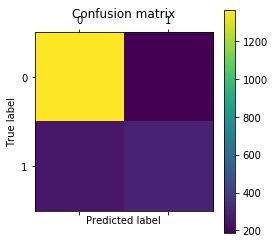

In [135]:
### display confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

In [136]:
# This is an improved RF model based on F1+, but it's inferior to several other models

### RF3: Try without bootstrap sampling

In [137]:
### The performance of this model decreased, so we'll keep boostrap sampling
### The code below works.

In [138]:
#rf = RandomForestClassifier(n_estimators = 750, criterion = 'entropy', max_features=15, random_state=RANDOM_SEED,
#                         bootstrap=False) 
# output the classifier
#print(rf)
#rf.fit(X_train, y_train)
       
#rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
#scores = cross_val_score(rf, X_test, y_test, cv=5)
#print(scores)
#print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

#print(mt.classification_report(y_test, rf_predictions))


In [139]:
#print(rf.score(X_test, y_test))
#scores = cross_val_score(rf, X_test, y_test, cv=5)
#print(scores)
#print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

#print(mt.classification_report(y_test, rf_predictions))


### RF4: No max features when looking for best split

In [140]:
rf = RandomForestClassifier(n_estimators = 750, criterion = 'entropy', max_features=None, random_state=RANDOM_SEED,
                           bootstrap=True) 
# output the classifier
print(rf)
rf.fit(X_train, y_train)     
rf_predictions = rf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


In [141]:
#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("RF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))


[0.81323877 0.80805687 0.79146919 0.76303318 0.78147268]
RF Accuracy: 0.79 (+/- 0.04)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1551
           1       0.62      0.54      0.58       559

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.71      0.72      2110
weighted avg       0.78      0.79      0.79      2110



[[1363  188]
 [ 256  303]]


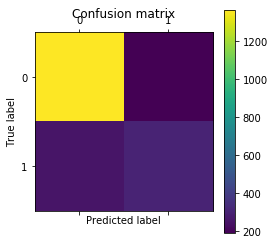

In [142]:
### display confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

In [143]:
# Slightly better recall and all other metrics the same as RF2.
# This is the best RF model

### Extra Trees / Feature Importances

In [144]:
# Let's see which features are best at predicting churn

Feature Ranking:
1. feature 3 (0.123715)
2. feature 1 (0.121532)
3. feature 2 (0.105174)
4. feature 36 (0.062046)
5. feature 18 (0.031643)
6. feature 27 (0.029779)
7. feature 0 (0.027049)
8. feature 43 (0.026857)
9. feature 16 (0.026084)
10. feature 5 (0.021813)
11. feature 4 (0.021357)
12. feature 38 (0.020053)
13. feature 21 (0.018495)
14. feature 39 (0.018317)
15. feature 40 (0.017815)
16. feature 24 (0.017425)
17. feature 6 (0.017407)
18. feature 7 (0.017321)
19. feature 42 (0.017144)
20. feature 12 (0.016520)
21. feature 14 (0.016057)
22. feature 41 (0.015494)
23. feature 33 (0.015395)
24. feature 35 (0.015371)
25. feature 26 (0.015086)
26. feature 8 (0.015006)
27. feature 9 (0.014977)
28. feature 32 (0.014485)
29. feature 30 (0.014385)
30. feature 23 (0.014015)
31. feature 44 (0.013580)
32. feature 29 (0.013027)
33. feature 20 (0.012856)
34. feature 37 (0.012661)
35. feature 15 (0.011217)
36. feature 10 (0.003416)
37. feature 13 (0.003301)
38. feature 25 (0.003183)
39. feature 11

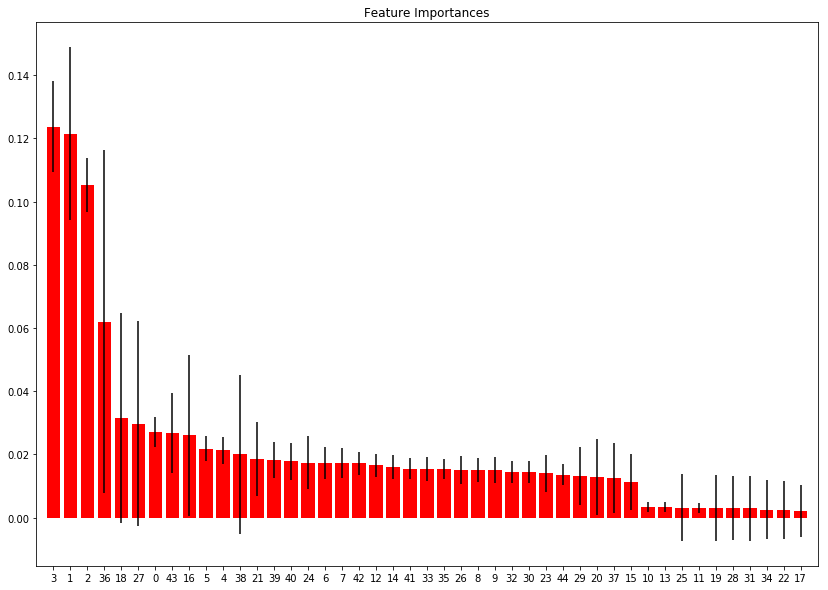

In [145]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=RANDOM_SEED)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(14,10))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [146]:
# We can see that features 1,2,and 3 are most important. Somewhat important is #36.
#1 - SeniorCitizen
#2 - tenure
#3 - MonthlyCharges
#36- StreamingMovies_Yes
list(df)

['Churn',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod

## Support Vector Machines (SVM)

### SVM-RBF1: default model

In [147]:
### CAUTION: this model will train very slowly
from sklearn.svm import SVC
# Default SVM RBF model
svc = SVC(kernel='rbf')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [148]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test) 

In [149]:
scores = cross_val_score(svc, X_test, y_test, cv=10)
print(scores)
print("RBF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
 
print(mt.classification_report(y_test, svc_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred)) 

[0.78301887 0.78672986 0.76777251 0.79146919 0.79620853 0.75829384
 0.73933649 0.76777251 0.75829384 0.77619048]
RBF Accuracy: 0.77 (+/- 0.03)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1551
           1       0.63      0.34      0.44       559

   micro avg       0.77      0.77      0.77      2110
   macro avg       0.71      0.63      0.65      2110
weighted avg       0.75      0.77      0.75      2110

Confusion Matrix:
[[1438  113]
 [ 370  189]]


In [150]:
# Good performance but not one of the best

#### Let's do a grid search

In [151]:
# Grid Search
param_grid = {'C': [1,5,10,25,50], 'gamma': [.0001,.0005,.001,.01,.1] }
grid = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 5, 10, 25, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [152]:
print(grid.best_params_, grid.best_score_)

{'C': 25, 'gamma': 0.001} 0.498485691762204


In [153]:
# Hone in on the parameters with another grid search
param_grid = {'C': [20,23,25,27,30,35], 'gamma': [.006,.008,.010,.020,.030,.040] }
grid = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [20, 23, 25, 27, 30, 35], 'gamma': [0.006, 0.008, 0.01, 0.02, 0.03, 0.04]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [154]:
print(grid.best_params_, grid.best_score_)

{'C': 20, 'gamma': 0.006} 0.4534380703170753


### SVM-RBF2: using recommended values for C and gamma

In [155]:
svc = SVC(C=35, gamma=.01, kernel='rbf')
print(svc)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test) 

SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [156]:
scores = cross_val_score(svc, X_test, y_test, cv=10)
print(scores)
print("RBF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
 
print(mt.classification_report(y_test, svc_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred))

[0.76415094 0.72985782 0.72985782 0.77251185 0.77251185 0.74881517
 0.69668246 0.7535545  0.7014218  0.73333333]
RBF Accuracy: 0.74 (+/- 0.05)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1551
           1       0.51      0.51      0.51       559

   micro avg       0.74      0.74      0.74      2110
   macro avg       0.66      0.67      0.67      2110
weighted avg       0.74      0.74      0.74      2110

Confusion Matrix:
[[1271  280]
 [ 272  287]]


Text(0.5, 0, 'Predicted label')

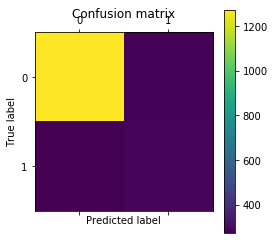

In [157]:
# Confusion matrix
cm = confusion_matrix(y_test, svc_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [158]:
# F1+ dropped 1%

### SVM-RBF3

In [159]:
### Can we hone in on C and gamma just a little more?

In [160]:
param_grid = {'C': [33,34,35,36,37,38], 'gamma': [.008,.009,.010,.011,.012,.013,.014] }
grid = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [33, 34, 35, 36, 37, 38], 'gamma': [0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [161]:
print(grid.best_params_, grid.best_score_)

{'C': 36, 'gamma': 0.008} 0.4397001682570396


In [162]:
# use updated values for C and gamma
svc = SVC(C=34, gamma=.014, kernel='rbf') 
print(svc)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

SVC(C=34, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.014, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [163]:
scores = cross_val_score(svc, X_test, y_test, cv=10)
print(scores)
print("RBF Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
 
print(mt.classification_report(y_test, svc_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred))

[0.77358491 0.73459716 0.73459716 0.78199052 0.75829384 0.74407583
 0.70616114 0.73933649 0.7014218  0.74285714]
RBF Accuracy: 0.74 (+/- 0.05)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1551
           1       0.52      0.49      0.50       559

   micro avg       0.74      0.74      0.74      2110
   macro avg       0.67      0.66      0.67      2110
weighted avg       0.74      0.74      0.74      2110

Confusion Matrix:
[[1297  254]
 [ 286  273]]


In [164]:
# F1+ dropped quite a bit

### SVM-Lin1: default linear model using LinearSVC classifier

In [165]:
from sklearn.svm import LinearSVC

In [166]:
svc_lin = LinearSVC()
print(svc_lin)
svc_lin.fit(X_train, y_train)
svc_pred = svc_lin.predict(X_test)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [167]:
scores = cross_val_score(svc_lin, X_test, y_test, cv=10)
print(scores)
print("SVC Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
 
print(mt.classification_report(y_test, svc_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred))

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklear

[0.76886792 0.78672986 0.74407583 0.70616114 0.64454976 0.74407583
 0.7535545  0.47867299 0.75829384 0.67142857]
SVC Accuracy: 0.71 (+/- 0.17)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1551
           1       0.56      0.72      0.63       559

   micro avg       0.78      0.78      0.78      2110
   macro avg       0.73      0.76      0.74      2110
weighted avg       0.80      0.78      0.79      2110

Confusion Matrix:
[[1239  312]
 [ 156  403]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [168]:
# Awful F1+ and appears to be over-fitting

### SVM-Lin2: default model using linear kernel of SVC classifier

#### This model takes a long time to run

In [169]:
from sklearn.svm import SVC

svm_lin = SVC(kernel='linear') 
print(svm_lin)
svm_lin.fit(X_train,y_train)
svm_pred = svm_lin.predict(X_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [170]:
scores = cross_val_score(svm_lin, X_test, y_test, cv=10)
print(scores)
print("SVM Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, svm_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

[0.80660377 0.79620853 0.81516588 0.8436019  0.81516588 0.77251185
 0.72511848 0.78199052 0.76303318 0.7952381 ]
SVM Accuracy: 0.79 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1551
           1       0.65      0.47      0.54       559

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.74      0.69      0.70      2110
weighted avg       0.78      0.79      0.78      2110

Confusion Matrix:
[[1408  143]
 [ 298  261]]


In [171]:
# Much better F1+ than SVM-Lin1, but still not good enough

#### Grid Search

In [ ]:
# TAKES A VERY, VERY LONG TIME TO RUN >>>>>> lower C to 0.5 or 0.1
#param_grid_lin = {'C': [.00001,.0001,.001,.01,.1,1,10,100]}
#grid_lin = GridSearchCV(svm_lin, param_grid=param_grid_lin, cv=3, 
#                        scoring='recall', n_jobs=-1)
#grid_lin.fit(X_train,y_train)
#print(grid_lin.best_params_, grid_lin.best_score_)

In [ ]:
# Should we spend time trying to hone in on a better value for C given the time factor?

In [ ]:
#param_grid_lin = {'C': [.8,1,2,3]}
#grid_lin = GridSearchCV(svc_lin, param_grid=param_grid_lin, cv=3, scoring='f1_weighted', n_jobs=-1)
#grid_lin.fit(X_train,y_train)              
#print(grid_lin.best_params_, grid_lin.best_score_)

### SVM-Lin3: lower C to 0.5

In [172]:
svm_lin = SVC(kernel='linear', C=0.5) 
print(svm_lin)
svm_lin.fit(X_train,y_train)
lin_pred = svm_lin.predict(X_test)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [173]:
scores = cross_val_score(svm_lin, X_test, y_test, cv=10)
print(scores)
print("SVM Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, lin_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, lin_pred))

[0.82075472 0.81990521 0.81042654 0.84834123 0.82464455 0.78672986
 0.73933649 0.8056872  0.75829384 0.7952381 ]
SVM Accuracy: 0.80 (+/- 0.06)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1551
           1       0.67      0.46      0.54       559

   micro avg       0.80      0.80      0.80      2110
   macro avg       0.75      0.69      0.71      2110
weighted avg       0.78      0.80      0.78      2110

Confusion Matrix:
[[1422  129]
 [ 302  257]]


In [174]:
# TIED FOR BEST SCORE SO FAR! We wouldn't have imagined this after such poor performance of Lin1.

## Artificial Neural Networks (ANN)

In [175]:
# IMPORT THE STANDARD SCALER
from sklearn.preprocessing import StandardScaler

In [176]:
# Scale the data
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [177]:
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### ANN1

In [178]:
from sklearn.neural_network import MLPClassifier

In [179]:
# We'll start with a small hidden layer size and the default learning rate of .001

mlp = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='sgd', 
                    learning_rate_init=0.001, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [180]:
scores = cross_val_score(mlp, X_test, y_test, cv=10)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))  

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

[0.73584906 0.73459716 0.73459716 0.73459716 0.73459716 0.73459716
 0.73459716 0.73459716 0.73459716 0.73809524]
ANN Accuracy: 0.74 (+/- 0.00)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1551
           1       0.67      0.52      0.59       559

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.76      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110

Confusion Matrix:
[[1409  142]
 [ 267  292]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [181]:
# Very good performance based on F1+, but not one of the best

### ANN2

In [182]:
# Increase the hidden layer size (46 is the max since we have 46 inputs/features)
mlp = MLPClassifier(hidden_layer_sizes=(15), activation='logistic', solver='sgd', 
                    learning_rate_init=0.001, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=15, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [183]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred)) 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

[0.8108747  0.78909953 0.79146919 0.77725118 0.78859857]
ANN Accuracy: 0.79 (+/- 0.02)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1551
           1       0.65      0.56      0.60       559

   micro avg       0.80      0.80      0.80      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.80      0.80      2110

Confusion Matrix:
[[1385  166]
 [ 247  312]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [184]:
# TIED FOR 3RD BEST F1+ SO FAR

### ANN3

In [185]:
# Now, we'll increase the learning rate (using the best model above: ANN1) 
mlp = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='sgd', 
                    learning_rate_init=0.005, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.005, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [186]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred)) 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.80378251 0.80094787 0.80805687 0.80331754 0.78859857]
ANN Accuracy: 0.80 (+/- 0.01)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1551
           1       0.65      0.58      0.61       559

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.75      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

Confusion Matrix:
[[1379  172]
 [ 237  322]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [187]:
# TIED FOR 2ND BEST F1+ SO FAR

### ANN4

In [188]:
# This time, we'll increase the learning rate a little more
mlp = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='sgd', learning_rate_init=0.01,
                   random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [189]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred)) 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

[0.80378251 0.80805687 0.80094787 0.81042654 0.80047506]
ANN Accuracy: 0.80 (+/- 0.01)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1551
           1       0.64      0.56      0.59       559

   micro avg       0.80      0.80      0.80      2110
   macro avg       0.74      0.72      0.73      2110
weighted avg       0.79      0.80      0.79      2110

Confusion Matrix:
[[1374  177]
 [ 248  311]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [190]:
# ALSO TIED FOR 2ND BEST F1+ SO FAR

### ANN5

In [191]:
# Lets try the adam solver using the best parameters
mlp = MLPClassifier(hidden_layer_sizes=(5), activation='logistic', solver='adam', 
                    learning_rate_init=0.01, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [192]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred)) 

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

[0.78959811 0.80331754 0.7985782  0.79146919 0.79809976]
ANN Accuracy: 0.80 (+/- 0.01)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1551
           1       0.62      0.55      0.58       559

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.71      0.72      2110
weighted avg       0.79      0.79      0.79      2110

Confusion Matrix:
[[1367  184]
 [ 253  306]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [193]:
# TIED FOR 3RD BEST OF ALL MODELS

### ANN6: Identity Function

In [194]:
# Lets try the Identity function using the best parameters
mlp = MLPClassifier(hidden_layer_sizes=(5), activation='identity', solver='sgd', 
                    learning_rate_init=0.01, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [195]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))

[0.81323877 0.8056872  0.81753555 0.7985782  0.79334917]
ANN Accuracy: 0.81 (+/- 0.02)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1551
           1       0.66      0.56      0.61       559

   micro avg       0.81      0.81      0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

Confusion Matrix:
[[1391  160]
 [ 245  314]]


In [196]:
# TIED FOR BEST MODEL OVERALL, BASED ON F1+ SCORE

### ANN7: Relu Function

In [197]:
# Lets try the Relu function using the best parameters
mlp = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='sgd', 
                    learning_rate_init=0.01, random_state=RANDOM_SEED)
# output the classifier
print(mlp)
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [198]:
scores = cross_val_score(mlp, X_test, y_test, cv=5)
print(scores)
print("ANN Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, mlp_pred)) 
print("Confusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))

C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

[0.79905437 0.7985782  0.7985782  0.77488152 0.78147268]
ANN Accuracy: 0.79 (+/- 0.02)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1551
           1       0.65      0.55      0.60       559

   micro avg       0.80      0.80      0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

Confusion Matrix:
[[1386  165]
 [ 251  308]]


C:\Users\SJT\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [199]:
# TIED FOR 3RD BEST OVERALL

### Let's try the voting classifier

In [200]:
from sklearn.ensemble import VotingClassifier

In [201]:
# Voting Classifier - Multiple Model Ensemble

evc = VotingClassifier(estimators = [('clf_knn',clf_knn),('SGD_clf',SGD_clf),('dt',dt),('rf',rf),('svc',svc),
                                     ('svm_lin',svm_lin),('mlp',mlp)], voting='hard')
# output the classifier
print(evc)

VotingClassifier(estimators=[('clf_knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='distance')), ('SGD_clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, ep...e=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)


In [202]:
### use the first line to save time
#evc.fit(X_train.iloc[1:1000], y_train.iloc[1:1000])
evc.fit(X_train, y_train)

VotingClassifier(estimators=[('clf_knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='distance')), ('SGD_clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, ep...e=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [203]:
evc.score(X_test, y_test)

0.7976303317535545

## WHAT'S THE BEST MODEL?

### Three models achieved the highest F1+ score:
#### 1) Decision Tree #4 (DT4)
#### 2) Linear Support Vector #3 (SVM-Lin3)
#### 3) Artificial Neural Network #6 (ANN6)

#### Notes: 
##### F1+ is the F1 score of the positive class (churn)
##### The highest score was 62%; the second highest was 61%; the third was 60%

#### Choosing the best model:

##### DT4 had the lowest accuracy among the best models: 74% +/- 7%
##### ANN6 results look very good, with an accuracy of 80% +/- 2%      <    <    <    <     BEST MODEL
##### The accuracy of SVM-Lin3 was similar at 80% +/- 4%
##### These models achieved the second highest score: AB2, ANN3, and ANN4

## RECOMMENDATIONS

### We recommend implementing model ANN6 (Artificial Neural Network #6).

### We also recommend adjusting marketing and customer outreach programs based on the business rules provided by Decision Tree #4, since neural networks provide no business information.

### Business rules provided by Decision Tree #4:
#### 1.	(a) If the customer is not on a month to month contract and their monthly charges are less than 43.73 and they’ve been with the company for less than 60 months, they are likely to churn; (b) if they’ve been with the company for at least 60 months, they are NOT likely to churn
#### 2.	(a) If the customer is not on a month to month contract and their monthly charges are at least 43.73 and they’re not on a two-year contract, they are likely to churn; (b) if they are on a two-year contract they are NOT likely to churn
#### 3.	(a) If the customer is on a month to month contract and they do not have fiber optic internet and they’ve been with the company for 4.5 months or less, they are likely to churn; (b) if they’ve been with the company over 4.5 months, they are NOT likely to churn
#### 4.	(a) If the customer is on a month to month contract and subscribes to fiber optic internet service and their total charges are less than 1,556.26, they are likely to churn; (b) if their total charges are at least 1,556.26, they are NOT likely to churn